In [1]:
# ----------------------------
# Core high-level wrapper
# ----------------------------
def compute_Fdiv_for_model_experiments(
    model_name,
    model_meta,
    experiments,
    base_dir,
    lon_slice=slice(0,360),
    season=(1,12),
    time_slice=None,   # slice(start_year, end_year)
):
    """
    Compute vertically-integrated divergent meridional MSE flux (F_div)
    for all requested experiments of a given model.

    Parameters
    ----------
    model_name : str
        Model name (e.g., "UKESM1-0-LL")
    model_meta : dict
        Metadata for the model (institution, ensemble, grid)
    experiments : dict
        Experiment metadata dict
    base_dir : Path
        Base CEDA path
    lon_slice : slice
        Longitude range to select
    season : tuple(int,int)
        Start and end month for seasonal mean
    time_slice : slice
        Start and end years, e.g., slice(2071, 2101)

    Returns
    -------
    Fdiv_by_exp : dict
        Keys are experiment names, values are xarray.DataArray (lat, lon)
    """

    Fdiv_by_exp = {}

    # List of variables we need
    varnames = ["ta","hus","zg","ua","va"]

    for exp, meta in experiments.items():

        # # Only compute for scenario experiments
        # if exp not in ["SSP245","G6solar","G6sulfur"]:
        #     continue

        # Ensemble overrides
        if model_name == "CESM2-WACCM":
            if meta["scenario"] == "G6sulfur":
                ensemble = "r1i1p1f2"
            else:
                ensemble = "r1i1p1f1"
        else:
            ensemble = model_meta["ensemble"]

        # ----------------------------
        # Function to open & slice a variable safely
        # ----------------------------
        def open_var(varname):
            base = (
                base_dir
                / meta["project"]
                / model_meta["institution"]
                / model_name
                / meta["scenario"]
                / ensemble
                / "Amon"
                / varname
                / model_meta["grid"]
                / "latest"
            )

            files = sorted(base.glob("*.nc"))
            if len(files) == 0:
                raise FileNotFoundError(f"No NetCDF files found in {base}")

            # Open with safe combine
            ds = xr.open_mfdataset(
                [str(f) for f in files],
                combine="nested",
                concat_dim="time",
                decode_times=True,
                use_cftime=True,
                parallel=True,
            )

            # Read variable
            da = mf.read_var(ds, varname)
            if da is None:
                raise ValueError(f"Variable {varname} not found in {base}")

            # Apply time slice if requested
            if time_slice is not None:
                start_year, end_year = time_slice.start, time_slice.stop-1
                da = da.sel(time=year_slice_to_cftime(da, start_year, end_year))

            return da

        # ----------------------------
        # Open all variables
        # ----------------------------
        ta  = open_var("ta")
        q   = open_var("hus")
        zg  = open_var("zg")
        ua  = open_var("ua")
        va  = open_var("va")

        # ----------------------------
        # Compute seasonal mean
        # ----------------------------
        start_month, end_month = season
        ta_mean = mf.seasonal_mean_by_year(ta, start_month, end_month).mean("year")
        q_mean  = mf.seasonal_mean_by_year(q,  start_month, end_month).mean("year")
        z_mean  = mf.seasonal_mean_by_year(zg, start_month, end_month).mean("year")
        ua_mean = mf.seasonal_mean_by_year(ua, start_month, end_month).mean("year")
        va_mean = mf.seasonal_mean_by_year(va, start_month, end_month).mean("year")

        print("printing original pressure values read from the data", va_mean.plev.values[:])

        # exit()
        
        # ----------------------------
        # Compute divergent winds
        # ----------------------------
        # Fill NaNs
        u_filled = ua_mean.fillna(0.0)
        v_filled = va_mean.fillna(0.0)

        # Barotropic mass correction
        # u_corr, v_corr = mf.barotropic_mass_correction(u_filled, v_filled)

        # Barotropic mass correction: sophisticated way
        ps_const = make_constant_ps_like(u_filled.isel(plev=0), value_hPa=1000.0)
        u_corr, v_corr = barotropic_mass_correction(u_filled, v_filled, plev=u_filled.plev, ps=ps_const) ;#use this function in this script
        # u_corr, v_corr = barotropic_mass_correction(u_filled, v_filled, ps=ps_const) ;#use this function in this script

        # VectorWind
        vw = VectorWind(u_corr, v_corr)
        u_div, v_div = vw.divergentcomponent()
        v_div_da = xr.DataArray(v_div, coords=va_mean.coords, dims=va_mean.dims, name="v_div")

        # ----------------------------
        # Select sector and compute MSE
        # ----------------------------
        lon_min, lon_max = lon_slice.start, lon_slice.stop
        ta_sec = ta_mean.sel(lon=lon_slice)
        q_sec  = q_mean.sel(lon=lon_slice)
        z_sec  = z_mean.sel(lon=lon_slice)
        v_sec  = v_div_da.sel(lon=lon_slice)

        # Compute moist static energy
        Cp = 1004.0
        Lv = 2.5e6
        g  = 9.81
        h = Cp*ta_sec + Lv*q_sec + g*z_sec

        # Interpolate h to wind grid
        h_on_v = h.interp(lat=v_sec.lat, lon=v_sec.lon, plev=v_sec.plev, method="linear")

        
        # Meridional MSE flux
        vh = v_sec * h_on_v


        ################ Before CLAUDE
        #################################
        # # Ensure monotonic plev and fill NaNs
        # vh_sorted = vh.sortby("plev").fillna(0.0)
        # plev_vals = np.array(vh_sorted.plev.values, dtype=float)
        # order = np.argsort(plev_vals)
        # vh_clean = vh_sorted.isel(plev=order).assign_coords(plev=plev_vals[order])

        # # Vertical integration
        # vh_int = vh_clean.integrate("plev")
        # F_div = vh_int / g  # W/m
        #################################


        
        #######Mid-point approach from Claude#########
        ##############################################
        # Ensure no NaNs
        vh_clean = vh.fillna(0.0)
        
        # Get the pressure levels
        plev = vh_clean.plev
        
        # -----------------------------
        # Compute layer thickness dp for each level (same as barotropic correction)
        # -----------------------------
        n_lev = len(plev)
        dp_vals = np.zeros(n_lev)
        
        # Top level (index 0): use distance to next level
        dp_vals[0] = abs(plev.values[1] - plev.values[0])
        
        # Interior levels: use centered difference
        for i in range(1, n_lev - 1):
            dp_vals[i] = abs(plev.values[i+1] - plev.values[i-1]) / 2.0
        
        # Bottom level: use distance to previous level
        dp_vals[-1] = abs(plev.values[-1] - plev.values[-2])
        
        # Create DataArray
        dp = xr.DataArray(dp_vals, coords={"plev": plev}, dims=["plev"])
        
        print("printing dp for vh integration:", dp)
        
        # Vertical integration: ∫ vh dp
        vh_int = (vh_clean * dp).sum("plev")
        
        # Divide by gravity to get final flux
        F_div = vh_int / g  # W/m

        # ----------------------------
        # Vertical integration (robust)
        # ----------------------------
        
        # # # 1. Sort by pressure (ascending: top → bottom)
        # # vh_sorted = vh.sortby("plev").fillna(0.0)
        
        # # plev = vh_sorted.plev  # should now be increasing (e.g., 10000 → 100000)
        
        # # # 2. Compute layer thickness dp (Pa)
        # # dp = plev.diff("plev")
        
        # # # Pad to keep same length
        # # dp = xr.concat([dp, dp.isel(plev=-1)], dim="plev")
        
        # # # Ensure positive thickness
        # # dp = abs(dp)
        
        # # # 3. Explicit pressure-weighted sum
        # # vh_int = (vh_sorted * dp).sum("plev")



        
        # # 1. Sort by pressure (ascending)
        # vh_sorted = vh.sortby("plev").fillna(0.0)
        # plev = vh_sorted.plev
        
        # # 2. Compute layer thickness using gradient (NO concat)
        # dp = xr.DataArray(
        #     np.gradient(plev.values),
        #     coords={"plev": plev},
        #     dims=["plev"],
        # )
        
        # dp = abs(dp)
        
        # # 3. Vertical integral
        # vh_int = (vh_sorted * dp).sum("plev")
        
        # 4. Divide by gravity
        # F_div = vh_int / g  # W m^-1
        #################################

        Fdiv_by_exp[exp] = F_div

    return Fdiv_by_exp

In [2]:
# ----------------------------
# Helper: convert integer years to cftime slice
# ----------------------------
def year_slice_to_cftime(da, start_year, end_year):
    """Convert integer years to cftime slice for a DataArray"""
    start = cftime.Datetime360Day(start_year, 1, 1)
    end   = cftime.Datetime360Day(end_year, 12, 30)
    return slice(start, end)


In [3]:
def barotropic_mass_correction(u, v, plev, ps):
    """
    Barotropic mass correction following Trenberth (1991)
    and Wei & Bordoni (2020) Supplementary Text S1.

    Parameters
    ----------
    u, v : xr.DataArray
        Zonal and meridional winds (plev, lat, lon)
    plev : xr.DataArray
        Pressure levels in Pa (plev,)
    ps : xr.DataArray
        Surface pressure (lat, lon)

    Returns
    -------
    u_corr, v_corr : xr.DataArray
        Barotropically corrected winds
    """

    g=9.81
    
    # #########Earlier: before Claude################
    # # -----------------------------
    # # 1. Compute layer thickness dp
    # # -----------------------------
    # dp = plev.diff("plev")
    # dp = xr.concat([dp.isel(plev=0), dp], dim="plev")
    # dp = dp.assign_coords(plev=plev)
    # print("printing dp from u_corr", dp)

    # # -------------------------------------------
    # # 2. Vertically integrated mass flux M = ∫ v dp
    # # -------------------------------------------
    # Mx = (u * dp).sum("plev")  # zonal mass flux
    # My = (v * dp).sum("plev")  # meridional mass flux

    # Mx = Mx.fillna(0.0)
    # My = My.fillna(0.0)

    ##########From Claude
    # # -----------------------------
    # # 1. Compute layer thickness dp
    # # -----------------------------
    # # Method 1: Use absolute value and proper edge handling
    # dp = abs(plev.diff("plev"))
    
    # # For the boundaries, duplicate the adjacent layer thickness
    # # Top boundary: duplicate first difference
    # # Bottom boundary: duplicate last difference
    # dp_top = dp.isel(plev=0)
    # dp = xr.concat([dp_top, dp], dim="plev")
    
    # # Reassign coordinates to match original plev
    # dp = dp.assign_coords(plev=plev)
    # print("printing dp from u_corr", dp)

    #######Mid-point approach from Claude#########
    # -----------------------------
    # 1. Compute layer thickness dp for each level
    # -----------------------------
    # For interior points: use centered difference
    # For boundaries: use one-sided difference
    
    n_lev = len(plev)
    dp_vals = np.zeros(n_lev)
    
    # Top level (index 0): use distance to next level
    dp_vals[0] = abs(plev.values[1] - plev.values[0])
    
    # Interior levels: use centered difference (distance to neighbors / 2 on each side)
    for i in range(1, n_lev - 1):
        dp_vals[i] = abs(plev.values[i+1] - plev.values[i-1]) / 2.0
    
    # Bottom level: use distance to previous level
    dp_vals[-1] = abs(plev.values[-1] - plev.values[-2])
    
    # Create DataArray
    dp = xr.DataArray(dp_vals, coords={"plev": plev}, dims=["plev"])

    print("printing dp before u_corr", dp)
    print("printing ps before u_corr", ps)
    

    
    # -------------------------------------------
    # 2. Vertically integrated mass flux M = (1/g) ∫ v dp
    # -------------------------------------------
    Mx = (u * dp).sum("plev") / g # zonal mass flux
    My = (v * dp).sum("plev") / g # meridional mass flux
    Mx = Mx.fillna(0.0)
    My = My.fillna(0.0)


    # ------------------------------------------------------------
    # 3. Extract DIVERGENT (irrotational) component of M using:
    #       M_div = ∇χ = vw.irrotationalcomponent()
    # ------------------------------------------------------------
    vwM = VectorWind(Mx, My)
    Mx_div, My_div = vwM.irrotationalcomponent()

    # THIS IS THE KEY FIX:
    p_t = plev.min()  # top level pressure
    atmospheric_mass = (ps - p_t) / g  # This is in kg/m²
    print("atmospheric_mass",atmospheric_mass)
    
    # ------------------------------------------------------------
    # 4. Barotropic correction: M_bt = - M_div / p_s
    #
    # Because we want:
    #    M + p_s * u_bt = M_nondivergent
    # => p_s * u_bt = - M_div
    # ------------------------------------------------------------
    u_bt = -Mx_div / atmospheric_mass ;#ps
    v_bt = -My_div / atmospheric_mass ;#ps

    # ------------------------------------------------------------
    # 5. Expand barotropic correction to all vertical levels
    # ------------------------------------------------------------
    u_bt_3D = u_bt.expand_dims({"plev": u.plev}, axis=0)
    v_bt_3D = v_bt.expand_dims({"plev": v.plev}, axis=0)

    u_corr = u + u_bt_3D
    v_corr = v + v_bt_3D

    return u_corr, v_corr


In [4]:
# def barotropic_mass_correction(u, v, plev, ps):
#     """
#     Barotropic mass correction following Trenberth (1991)
#     and Wei & Bordoni (2020) Supplementary Text S1.

#     Parameters
#     ----------
#     u, v : xr.DataArray
#         Zonal and meridional winds (plev, lat, lon)
#     plev : xr.DataArray
#         Pressure levels in Pa (plev,)
#     ps : xr.DataArray
#         Surface pressure (lat, lon)

#     Returns
#     -------
#     u_corr, v_corr : xr.DataArray
#         Barotropically corrected winds
#     """

#     # # -----------------------------
#     # # 1. Compute layer thickness dp
#     # # -----------------------------
#     # # dp = plev.diff("plev")
#     # # dp = xr.concat([dp.isel(plev=0), dp], dim="plev")
#     # # dp = dp.assign_coords(plev=plev)
#     # #### plev_sorted = plev.sortby("plev")
#     # #### dp = plev_sorted.diff("plev")
#     # #### dp = xr.concat([dp, dp.isel(plev=-1)], dim="plev")
#     # #### dp = abs(dp)


    
#     # # 1. Sort by pressure (ascending: top → bottom)
#     # pp=plev
#     # plev_sorted = pp.sortby("plev").fillna(0.0)
    
#     # plev_increasing = plev_sorted.plev  # should now be increasing (e.g., 10000 → 100000)
    
#     # # 2. Compute layer thickness dp (Pa)
#     # dp = plev_increasing.diff("plev")
    
#     # # Pad to keep same length
#     # dp = xr.concat([dp, dp.isel(plev=-1)], dim="plev")
    
#     # # Ensure positive thickness
#     # dp = abs(dp)

#     # # -------------------------------------------
#     # # 2. Vertically integrated mass flux M = ∫ v dp
#     # # -------------------------------------------
#     # Mx = (u * dp).sum("plev")  # zonal mass flux
#     # My = (v * dp).sum("plev")  # meridional mass flux

#     # Mx = Mx.fillna(0.0)
#     # My = My.fillna(0.0)
#     # -----------------------------
#     # 1. Ensure pressure increases upward
#     # -----------------------------
#     u_sorted = u.sortby("plev")
#     v_sorted = v.sortby("plev")
    
#     plev = u_sorted.plev  # now strictly increasing
    
#     # -----------------------------
#     # 2. Compute layer thickness (Pa)
#     # -----------------------------
#     dp = plev.diff("plev")
    
#     # Pad to match dimension length
#     dp = xr.concat([dp, dp.isel(plev=-1)], dim="plev")
    
#     # Make positive
#     dp = abs(dp)
    
#     # Broadcast dp to 3D
#     dp_3D = dp.broadcast_like(u_sorted)
    
#     # -------------------------------------------
#     # 3. Vertically integrated mass flux
#     # -------------------------------------------
#     Mx = (u_sorted * dp_3D).sum("plev")
#     My = (v_sorted * dp_3D).sum("plev")
    
#     Mx = Mx.fillna(0.0)
#     My = My.fillna(0.0)
#     # ------------------------------------------------------------
#     # 3. Extract DIVERGENT (irrotational) component of M using:
#     #       M_div = ∇χ = vw.irrotationalcomponent()
#     # ------------------------------------------------------------
#     vwM = VectorWind(Mx, My)
#     Mx_div, My_div = vwM.irrotationalcomponent()

#     # ------------------------------------------------------------
#     # 4. Barotropic correction: M_bt = - M_div / p_s
#     #
#     # Because we want:
#     #    M + p_s * u_bt = M_nondivergent
#     # => p_s * u_bt = - M_div
#     # ------------------------------------------------------------
#     u_bt = -Mx_div / ps
#     v_bt = -My_div / ps

#     # ------------------------------------------------------------
#     # 5. Expand barotropic correction to all vertical levels
#     # ------------------------------------------------------------
#     u_bt_3D = u_bt.expand_dims({"plev": u_sorted.plev}, axis=0)
#     v_bt_3D = v_bt.expand_dims({"plev": v_sorted.plev}, axis=0)

#     u_corr = u + u_bt_3D
#     v_corr = v + v_bt_3D

#     return u_corr, v_corr


In [5]:
# #Trial function : did not work ... sort of ... gave units ~ 10^10

# def barotropic_mass_correction(u, v, ps, g=9.81):
#     """
#     Barotropic mass correction following Trenberth (1991)
#     and Wei & Bordoni (2020) Supplementary Text S1.

#     Parameters
#     ----------
#     u, v : xr.DataArray
#         Zonal and meridional winds (plev, lat, lon)
#     ps : xr.DataArray
#         Surface pressure (lat, lon)
#     g : float
#         Gravity (m s^-2)

#     Returns
#     -------
#     u_corr, v_corr : xr.DataArray
#         Barotropically corrected winds
#     """

#     # -------------------------------------------------
#     # 1. Sort everything consistently by pressure
#     # -------------------------------------------------
#     u = u.sortby("plev")
#     v = v.sortby("plev")
#     plev = u.plev

#     # -------------------------------------------------
#     # 2. Compute layer thickness dp (Pa)
#     #    Use gradient → same length, no duplicates
#     # -------------------------------------------------
#     dp = xr.DataArray(
#         np.gradient(plev.values),
#         coords={"plev": plev},
#         dims=["plev"],
#     )

#     dp = abs(dp)

#     # -------------------------------------------------
#     # 3. Vertically integrated mass flux
#     #    M = ∫ v dp   (NO division by g here)
#     # -------------------------------------------------
#     Mx = (u * dp).sum("plev")
#     My = (v * dp).sum("plev")

#     Mx = Mx.fillna(0.0)
#     My = My.fillna(0.0)

#     # -------------------------------------------------
#     # 4. Extract divergent component
#     # -------------------------------------------------
#     vwM = VectorWind(Mx, My)
#     Mx_div, My_div = vwM.irrotationalcomponent()

#     # -------------------------------------------------
#     # 5. Barotropic correction
#     #    p_s * u_bt = - M_div
#     # -------------------------------------------------
#     u_bt = -Mx_div / ps
#     v_bt = -My_div / ps

#     # -------------------------------------------------
#     # 6. Apply correction uniformly to all levels
#     # -------------------------------------------------
#     u_corr = u + u_bt.expand_dims(plev=plev)
#     v_corr = v + v_bt.expand_dims(plev=plev)

#     return u_corr, v_corr

In [6]:
import numpy as np
import xarray as xr

def make_constant_ps_like(sample_da, value_hPa=1000.0):
    """
    Create a constant surface-pressure DataArray on the (lat, lon) grid of 'sample_da'.

    Parameters
    ----------
    sample_da : xr.DataArray or xr.Dataset
        Any object that contains 'lat' and 'lon' coordinates on the target grid.
        Typically use u.isel(plev=0) or v.isel(plev=0) or any 2-D field with (lat, lon).
    value_hPa : float
        Constant surface pressure in hPa (default: 1000 hPa).

    Returns
    -------
    ps : xr.DataArray
        Surface pressure (Pa) with dims ('lat', 'lon') on the same grid as sample_da.
    """
    # get coords from the sample
    lat = sample_da['lat']
    lon = sample_da['lon']

    ps_values = np.full((lat.size, lon.size), value_hPa * 100.0, dtype=np.float32)  # convert hPa -> Pa
    ps = xr.DataArray(
        ps_values,
        coords={'lat': lat, 'lon': lon},
        dims=('lat', 'lon'),
        name='ps'
    )
    ps.attrs.update({'units': 'Pa', 'long_name': f'Constant surface pressure ({value_hPa:.0f} hPa)'})
    return ps

The aim is to read plot EFE

1) Adam, O., T. Bischoff, and T. Schneider, 2016: Seasonal and Interannual Variations of the Energy Flux Equator and ITCZ. Part I: Zonally Averaged ITCZ Position. J. Climate, 29, 3219–3230, https://doi.org/10.1175/JCLI-D-15-0512.1.
2) EFPM : NOT USING NOW. keeping the reference here: Boos, W., Korty, R. Regional energy budget control of the intertropical convergence zone and application to mid-Holocene rainfall. Nature Geosci 9, 892–897 (2016). https://doi.org/10.1038/ngeo2833


In [7]:
import numpy as np
import xarray as xr
import matplotlib as mpl
from pathlib import Path

# our local module:
import itcz
import myfunctions as mf
from windspharm.standard import VectorWind
import cftime

In [8]:
# =========================
# User-defined metadata
# =========================

# Base CEDA paths
CEDA_BASE = Path("/badc/cmip6/data/CMIP6")

#Model Names
MODELS = {
    "UKESM1-0-LL":  {"institution": "MOHC",         "ensemble": "r1i1p1f2",  "grid": "gn",},
    # "CNRM-ESM2-1":  {"institution": "CNRM-CERFACS", "ensemble": "r1i1p1f2",  "grid": "gr",},
    # "MPI-ESM1-2-LR":{"institution": "MPI-M",        "ensemble": "r1i1p1f1",  "grid": "gn",},
    # "CESM2-WACCM":  {"institution": "NCAR",         "ensemble": "r1i1p1f1",  "grid": "gn",},
    # "IPSL-CM6A-LR": {"institution": "IPSL",         "ensemble": "r1i1p1f1",  "grid": "gr",},
}

#Experiment details
EXPERIMENTS = {
    # "HIST":     {"project": "CMIP",        "scenario": "historical", "color": "black"},
    "SSP245":   {"project": "ScenarioMIP", "scenario": "ssp245"},
    # "SSP585":   {"project": "ScenarioMIP", "scenario": "ssp585"},
    # "G6solar":  {"project": "GeoMIP",      "scenario": "G6solar"},
    # "G6sulfur": {"project": "GeoMIP",      "scenario": "G6sulfur"},
}




In [9]:
from pathlib import Path

base = CEDA_BASE / "CMIP" / "MOHC" / "UKESM1-0-LL" / "historical" / "r1i1p1f2" / "Amon" / "zg" / "gn" / "latest"
files = sorted(base.glob("*.nc"))
print(len(files), "files found")


2 files found


In [10]:
Fdiv_UKESM_2071_2100 = compute_Fdiv_for_model_experiments(
    model_name="UKESM1-0-LL",
    model_meta=MODELS["UKESM1-0-LL"],
    experiments=EXPERIMENTS,
    base_dir=CEDA_BASE,
    lon_slice=slice(0, 360),
    season=(1, 12),
    time_slice=slice(2071, 2101),
)


printing original pressure values read from the data [100000.  92500.  85000.  70000.  60000.  50000.  40000.  30000.  25000.
  20000.  15000.  10000.   7000.   5000.   3000.   2000.   1000.    500.
    100.]
printing dp before u_corr <xarray.DataArray (plev: 19)> Size: 152B
array([ 7500.,  7500., 11250., 12500., 10000., 10000., 10000.,  7500.,
        5000.,  5000.,  5000.,  4000.,  2500.,  2000.,  1500.,  1000.,
         750.,   450.,   400.])
Coordinates:
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
printing ps before u_corr <xarray.DataArray 'ps' (lat: 145, lon: 192)> Size: 111kB
array([[100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       ...,
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000.

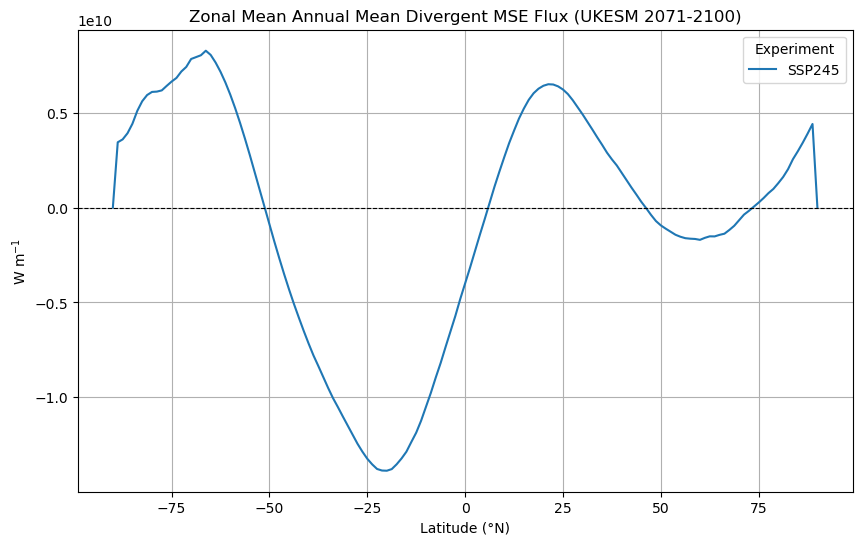

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for exp, da in Fdiv_UKESM_2071_2100.items():
    # Compute zonal mean
    zonal_mean = da.mean("lon")
    
    # Plot
    plt.plot(da.lat, zonal_mean, marker='', label=exp)

plt.xlabel("Latitude (°N)")
plt.ylabel(r"W m$^{-1}$")
plt.title("Zonal Mean Annual Mean Divergent MSE Flux (UKESM 2071-2100)")
plt.grid(True)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.legend(title="Experiment")
plt.show()


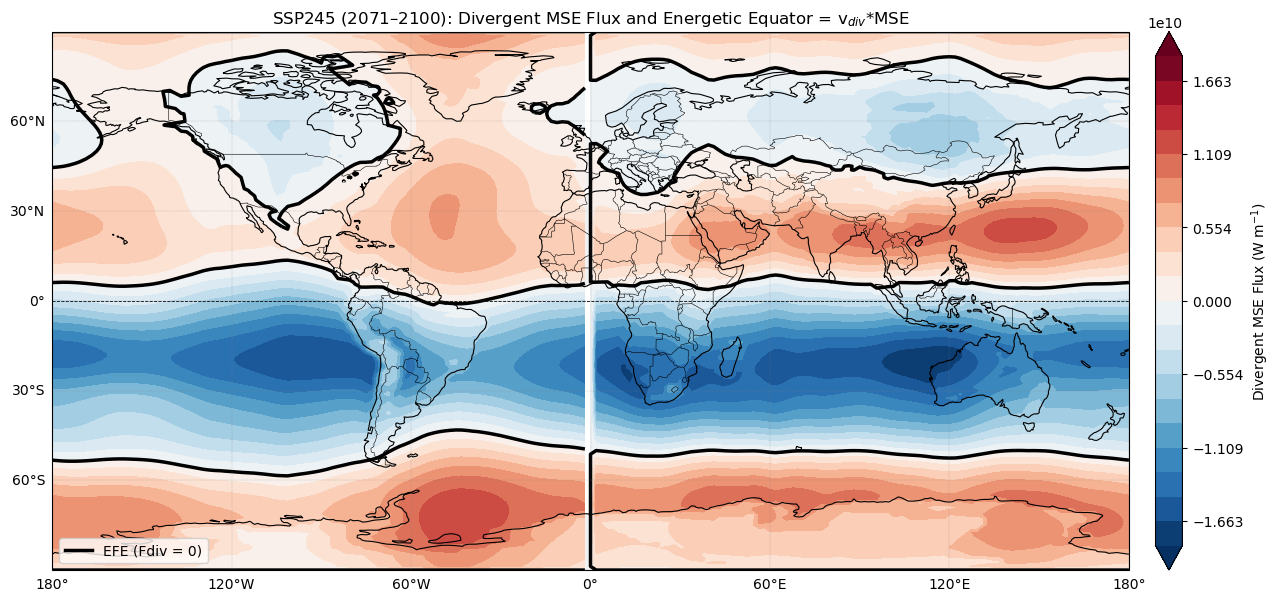

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# =====================
# Parameters
# =====================
trop_lat   = 90
num_levels = 21

# =====================
# Extract data
# =====================
Fdiv = Fdiv_UKESM_2071_2100["SSP245"]
# ITCZ = ITCZ_Adam_UKESM_2071_2100["SSP245"]


# =====================
# Slice to tropics
# =====================
Fdiv_trop = Fdiv.sel(lat=slice(-trop_lat, trop_lat))

# =====================
# Adam ITCZ mean (over years)
# =====================
# itcz_mean = ITCZ.mean("year")

# --- Wrap longitudes (0–360 → -180–180) ---
lon = Fdiv.lon.values
lon_wrap = ((lon + 180) % 360) - 180
sort_idx = np.argsort(lon_wrap)

lon_sorted  = lon_wrap[sort_idx]
# itcz_sorted = itcz_mean.values[sort_idx]

# =====================
# Figure and axes
# =====================
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# =====================
# Divergent MSE shading
# =====================
vmax = np.nanmax(np.abs(Fdiv_trop))
levels = np.linspace(-vmax, vmax, num_levels)

cf = ax.contourf(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=levels,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree(),
)

# =====================
# Zero contour (EFE)
# =====================
ax.contour(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=[0],
    colors="black",
    linewidths=2.5,
    transform=ccrs.PlateCarree(),
)

# # =====================
# # Adam ITCZ (thick green)
# # =====================
# ax.plot(
#     lon_sorted,
#     itcz_sorted,
#     color="green",
#     linewidth=3.5,
#     transform=ccrs.PlateCarree(),
# )

# =====================
# Reference equator
# =====================
ax.axhline(0, color="k", linewidth=0.6, linestyle="--")

# =====================
# Cartopy features
# =====================
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# =====================
# Gridlines
# =====================
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.3,
    color="gray",
    alpha=0.5,
    linestyle="--",
)
gl.top_labels = False
gl.right_labels = False

# =====================
# Legend
# =====================
legend_elements = [
    Line2D([0], [0], color="black", lw=2.5, label="EFE (Fdiv = 0)"),
    # Line2D([0], [0], color="green", lw=3.5, label="Adam ITCZ"),
]
ax.legend(handles=legend_elements, loc="lower left")

# =====================
# Colorbar
# =====================
# cbar = plt.colorbar(
#     cf,
#     ax=ax,
#     orientation="horizontal",
#     pad=0.06,
#     aspect=40,
# )

cbar = plt.colorbar(cf, ax=ax, orientation="vertical", pad=0.02)
# cbar.set_label("Divergent MSE flux (10^8 W m$^{-1}$)")
cbar.set_label("Divergent MSE Flux (W m$^{-1}$)")

# =====================
# Title
# =====================
ax.set_title(
    "SSP245 (2071–2100): Divergent MSE Flux and Energetic Equator = v$_{div}$*MSE"
)

plt.tight_layout()
plt.show()


I read the thermodynamic and dynamic variables. Use barotropic mass correction on u and v. Then use vectorwind from windspharm.standard on barotropic mass corrected u and v. from there I get v_div. 

I used the thermodynamic variables to compute MSE. Multiply MSE with v_div.  Then I compute the vertical integral/g

In [13]:
print("Fdiv max:", Fdiv.max().values)
print("Fdiv min:", Fdiv.min().values)
print("Fdiv range:", Fdiv.max().values - Fdiv.min().values)

Fdiv max: 12454413993.369173
Fdiv min: -18478848156.849075
Fdiv range: 30933262150.218246


/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)


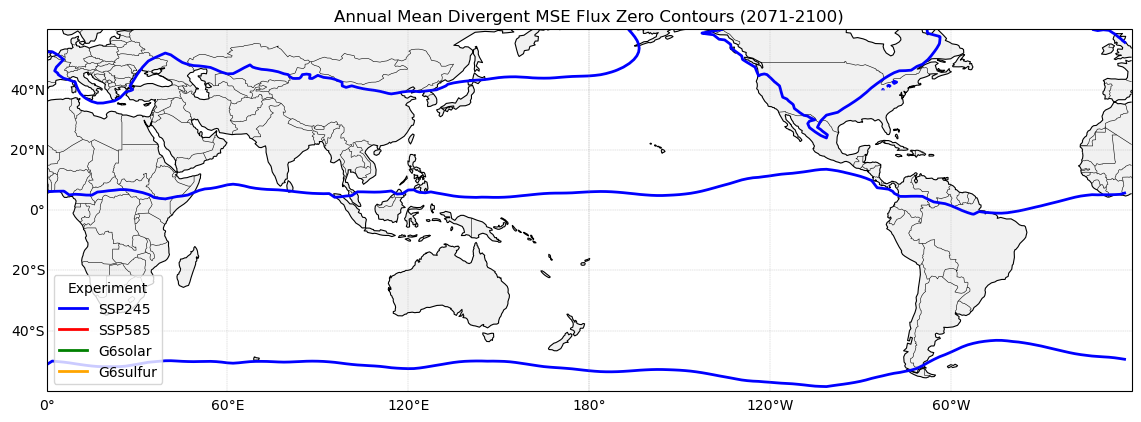

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- Parameters ---
trop_lat = 60
colors = {
    "SSP245": "blue",
    "SSP585": "red",
    "G6solar": "green",
    "G6sulfur": "orange"
}

# --- Figure and axes ---
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# --- Plot zero contours for each experiment ---
for exp, da in Fdiv_UKESM_2071_2100.items():
    # Slice to tropics
    da_tropics = da.sel(lat=slice(-trop_lat, trop_lat))
    
    # Plot zero contour only
    ax.contour(
        da_tropics.lon,
        da_tropics.lat,
        da_tropics,
        levels=[0],
        colors=colors.get(exp, "black"),
        linewidths=2,
        transform=ccrs.PlateCarree(),
        label=exp  # note: contour doesn’t handle label directly
    )

# --- Cartopy features ---
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# --- Gridlines ---
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# --- Manual legend for contours ---
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, lw=2, label=exp) for exp, c in colors.items()]
ax.legend(handles=legend_elements, title="Experiment", loc="lower left")

ax.set_title("Annual Mean Divergent MSE Flux Zero Contours (2071-2100)")

plt.show()


In [15]:
#IMMEDIATELY AFTER SAI APPLICATION

Fdiv_UKESM_2020_2050 = compute_Fdiv_for_model_experiments(
    model_name="UKESM1-0-LL",
    model_meta=MODELS["UKESM1-0-LL"],
    experiments=EXPERIMENTS,
    base_dir=CEDA_BASE,
    lon_slice=slice(0, 360),
    season=(1, 12),
    time_slice=slice(2021, 2051),
)

printing original pressure values read from the data [100000.  92500.  85000.  70000.  60000.  50000.  40000.  30000.  25000.
  20000.  15000.  10000.   7000.   5000.   3000.   2000.   1000.    500.
    100.]
printing dp before u_corr <xarray.DataArray (plev: 19)> Size: 152B
array([ 7500.,  7500., 11250., 12500., 10000., 10000., 10000.,  7500.,
        5000.,  5000.,  5000.,  4000.,  2500.,  2000.,  1500.,  1000.,
         750.,   450.,   400.])
Coordinates:
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
printing ps before u_corr <xarray.DataArray 'ps' (lat: 145, lon: 192)> Size: 111kB
array([[100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       ...,
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000., 100000., ..., 100000., 100000., 100000.],
       [100000., 100000.

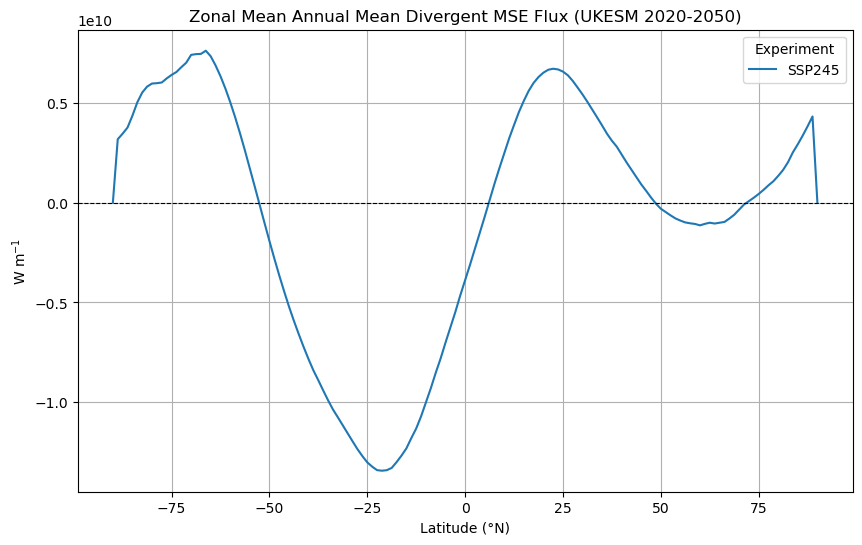

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for exp, da in Fdiv_UKESM_2020_2050.items():
    # Compute zonal mean
    zonal_mean = da.mean("lon")
    
    # Plot
    plt.plot(da.lat, zonal_mean, marker='', label=exp)

plt.xlabel("Latitude (°N)")
plt.ylabel(r"W m$^{-1}$")
plt.title("Zonal Mean Annual Mean Divergent MSE Flux (UKESM 2020-2050)")
plt.grid(True)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.legend(title="Experiment")
plt.show()


/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)


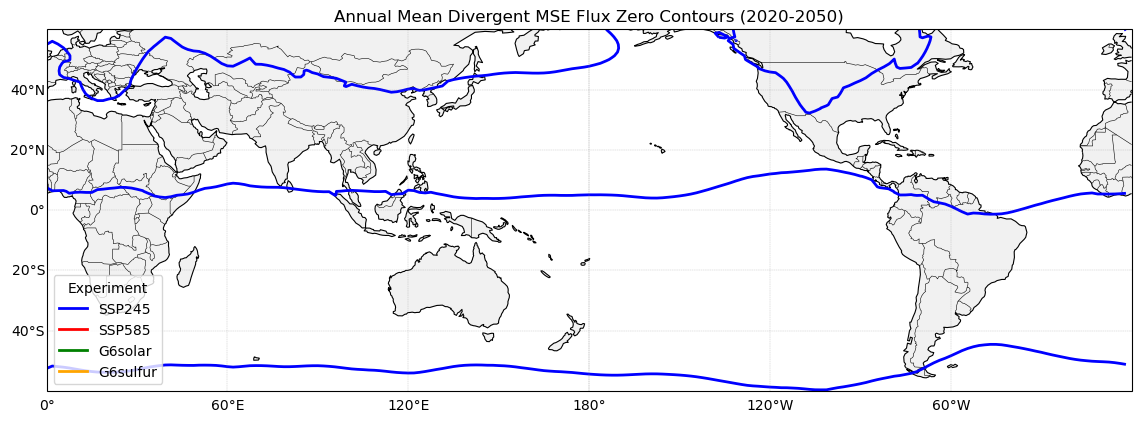

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- Parameters ---
trop_lat = 60
colors = {
    "SSP245": "blue",
    "SSP585": "red",
    "G6solar": "green",
    "G6sulfur": "orange"
}

# --- Figure and axes ---
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# --- Plot zero contours for each experiment ---
for exp, da in Fdiv_UKESM_2020_2050.items():
    # Slice to tropics
    da_tropics = da.sel(lat=slice(-trop_lat, trop_lat))
    
    # Plot zero contour only
    ax.contour(
        da_tropics.lon,
        da_tropics.lat,
        da_tropics,
        levels=[0],
        colors=colors.get(exp, "black"),
        linewidths=2,
        transform=ccrs.PlateCarree(),
        label=exp  # note: contour doesn’t handle label directly
    )

# --- Cartopy features ---
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# --- Gridlines ---
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# --- Manual legend for contours ---
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, lw=2, label=exp) for exp, c in colors.items()]
ax.legend(handles=legend_elements, title="Experiment", loc="lower left")

ax.set_title("Annual Mean Divergent MSE Flux Zero Contours (2020-2050)")

plt.show()


In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# --- Parameters ---
trop_lat = 60

# --- Extract G6sulfur ---
Fdiv_2020 = Fdiv_UKESM_2020_2050["G6sulfur"]
Fdiv_2071 = Fdiv_UKESM_2071_2100["G6sulfur"]

# --- Slice to tropics ---
Fdiv_2020_trop = Fdiv_2020.sel(lat=slice(-trop_lat, trop_lat))
Fdiv_2071_trop = Fdiv_2071.sel(lat=slice(-trop_lat, trop_lat))

# --- Figure and axes ---
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# --- Zero contours ---
ax.contour(
    Fdiv_2020_trop.lon,
    Fdiv_2020_trop.lat,
    Fdiv_2020_trop,
    levels=[0],
    colors="orange",
    linewidths=2,
    linestyles="solid",
    transform=ccrs.PlateCarree(),
)

ax.contour(
    Fdiv_2071_trop.lon,
    Fdiv_2071_trop.lat,
    Fdiv_2071_trop,
    levels=[0],
    colors="brown",
    linewidths=2,
    linestyles="dashed",
    transform=ccrs.PlateCarree(),
)

# --- Cartopy features ---
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# --- Gridlines ---
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray",
                  alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# --- Legend ---
legend_elements = [
    Line2D([0], [0], color="orange", lw=2, linestyle="solid",
           label="G6sulfur 2020–2050"),
    Line2D([0], [0], color="brown", lw=2, linestyle="dashed",
           label="G6sulfur 2071–2100"),
]
ax.legend(handles=legend_elements, loc="lower left")

ax.set_title("Zero Contours of Divergent MSE Flux (G6sulfur)")

plt.show()


KeyError: 'G6sulfur'

In [ ]:
import itcz
ITCZ_Adam_UKESM_2071_2100 = itcz.compute_adam_ITCZ(
    model_name="UKESM1-0-LL",
    model_meta=MODELS["UKESM1-0-LL"],
    experiments=EXPERIMENTS,
    base_dir=CEDA_BASE,
    lon_slice=slice(0, 360),
    season=(1, 12),
    time_slice=slice(2071, 2101),
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# --- Parameters ---
trop_lat = 60

# --- Extract data ---
Fdiv = Fdiv_UKESM_2071_2100["G6sulfur"]
ITCZ = ITCZ_Adam_UKESM_2071_2100["G6sulfur"]

# --- Slice Fdiv to tropics ---
Fdiv_trop = Fdiv.sel(lat=slice(-trop_lat, trop_lat))

# --- ITCZ mean over years ---
itcz_mean = ITCZ.mean("year")

# --- Wrap longitudes (0–360 → -180–180) ---
lon = itcz_mean.lon.values
lon_wrap = ((lon + 180) % 360) - 180
sort_idx = np.argsort(lon_wrap)

lon_sorted  = lon_wrap[sort_idx]
itcz_sorted = itcz_mean.values[sort_idx]

# --- Figure and axes ---
fig = plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# --- Fdiv zero contour (G6sulfur, 2071–2100) ---
ax.contour(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=[0],
    colors="brown",
    linewidths=2,
    transform=ccrs.PlateCarree(),
)

# --- Adam ITCZ line ---
ax.plot(
    lon_sorted,
    itcz_sorted,
    color="black",
    linewidth=2.5,
    transform=ccrs.PlateCarree(),
    label="Adam ITCZ (mean, 2071–2100)",
)

# --- Reference equator ---
ax.axhline(0, color="k", linewidth=0.6, linestyle="--")

# --- Cartopy features ---
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# --- Gridlines ---
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray",
                  alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False

# --- Legend ---
legend_elements = [
    Line2D([0], [0], color="brown", lw=2, label="EFE"),
    Line2D([0], [0], color="black", lw=2.5, label="Adam ITCZ"),
]
ax.legend(handles=legend_elements, loc="lower left")

ax.set_title("G6sulfur (2071–2100): Wei_Bordoni_2020_EFE and Adam_2016_ITCZ")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# =====================
# Parameters
# =====================
trop_lat   = 60
num_levels = 21

# =====================
# Extract data
# =====================
Fdiv = Fdiv_UKESM_2071_2100["G6sulfur"]
ITCZ = ITCZ_Adam_UKESM_2071_2100["G6sulfur"]

# =====================
# Slice to tropics
# =====================
Fdiv_trop = Fdiv.sel(lat=slice(-trop_lat, trop_lat))

# =====================
# Adam ITCZ mean (over years)
# =====================
itcz_mean = ITCZ.mean("year")

# --- Wrap longitudes (0–360 → -180–180) ---
lon = itcz_mean.lon.values
lon_wrap = ((lon + 180) % 360) - 180
sort_idx = np.argsort(lon_wrap)

lon_sorted  = lon_wrap[sort_idx]
itcz_sorted = itcz_mean.values[sort_idx]

# =====================
# Figure and axes
# =====================
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# =====================
# Divergent MSE shading
# =====================
vmax = np.nanmax(np.abs(Fdiv_trop))
levels = np.linspace(-vmax, vmax, num_levels)

cf = ax.contourf(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=levels,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree(),
)

# =====================
# Zero contour (EFE)
# =====================
ax.contour(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=[0],
    colors="black",
    linewidths=2.5,
    transform=ccrs.PlateCarree(),
)

# =====================
# Adam ITCZ (thick green)
# =====================
ax.plot(
    lon_sorted,
    itcz_sorted,
    color="green",
    linewidth=3.5,
    transform=ccrs.PlateCarree(),
)

# =====================
# Reference equator
# =====================
ax.axhline(0, color="k", linewidth=0.6, linestyle="--")

# =====================
# Cartopy features
# =====================
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# =====================
# Gridlines
# =====================
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.3,
    color="gray",
    alpha=0.5,
    linestyle="--",
)
gl.top_labels = False
gl.right_labels = False

# =====================
# Legend
# =====================
legend_elements = [
    Line2D([0], [0], color="black", lw=2.5, label="EFE (Fdiv = 0)"),
    Line2D([0], [0], color="green", lw=3.5, label="Adam ITCZ"),
]
ax.legend(handles=legend_elements, loc="lower left")

# =====================
# Colorbar
# =====================
cbar = plt.colorbar(
    cf,
    ax=ax,
    orientation="horizontal",
    pad=0.06,
    aspect=40,
)
cbar.set_label("Divergent MSE Flux (W m$^{-1}$)")

# =====================
# Title
# =====================
ax.set_title(
    "G6sulfur (2071–2100): Divergent MSE Flux, Energetic Equator, and Adam ITCZ"
)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# =====================
# Parameters
# =====================
trop_lat   = 90
num_levels = 21

# =====================
# Extract data
# =====================
Fdiv = Fdiv_UKESM_2071_2100["SSP245"]
ITCZ = ITCZ_Adam_UKESM_2071_2100["SSP245"]

# =====================
# Slice to tropics
# =====================
Fdiv_trop = Fdiv.sel(lat=slice(-trop_lat, trop_lat))

# =====================
# Adam ITCZ mean (over years)
# =====================
itcz_mean = ITCZ.mean("year")

# --- Wrap longitudes (0–360 → -180–180) ---
lon = itcz_mean.lon.values
lon_wrap = ((lon + 180) % 360) - 180
sort_idx = np.argsort(lon_wrap)

lon_sorted  = lon_wrap[sort_idx]
itcz_sorted = itcz_mean.values[sort_idx]

# =====================
# Figure and axes
# =====================
fig = plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -trop_lat, trop_lat], crs=ccrs.PlateCarree())

# =====================
# Divergent MSE shading
# =====================
vmax = np.nanmax(np.abs(Fdiv_trop))
levels = np.linspace(-vmax, vmax, num_levels)

cf = ax.contourf(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=levels,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree(),
)

# =====================
# Zero contour (EFE)
# =====================
ax.contour(
    Fdiv_trop.lon,
    Fdiv_trop.lat,
    Fdiv_trop,
    levels=[0],
    colors="black",
    linewidths=2.5,
    transform=ccrs.PlateCarree(),
)

# =====================
# Adam ITCZ (thick green)
# =====================
ax.plot(
    lon_sorted,
    itcz_sorted,
    color="green",
    linewidth=3.5,
    transform=ccrs.PlateCarree(),
)

# =====================
# Reference equator
# =====================
ax.axhline(0, color="k", linewidth=0.6, linestyle="--")

# =====================
# Cartopy features
# =====================
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor="white")

# =====================
# Gridlines
# =====================
gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.3,
    color="gray",
    alpha=0.5,
    linestyle="--",
)
gl.top_labels = False
gl.right_labels = False

# =====================
# Legend
# =====================
legend_elements = [
    Line2D([0], [0], color="black", lw=2.5, label="EFE (Fdiv = 0)"),
    Line2D([0], [0], color="green", lw=3.5, label="Adam ITCZ"),
]
ax.legend(handles=legend_elements, loc="lower left")

# =====================
# Colorbar
# =====================
cbar = plt.colorbar(
    cf,
    ax=ax,
    orientation="horizontal",
    pad=0.06,
    aspect=40,
)
cbar.set_label("Divergent MSE Flux (W m$^{-1}$)")

# =====================
# Title
# =====================
ax.set_title(
    "SSP245 (2071–2100): Divergent MSE Flux, Energetic Equator, and Adam ITCZ"
)

plt.tight_layout()
plt.show()


In [ ]:
plt.plot(Fdiv_UKESM_2071_2100["SSP245"].lat, Fdiv_UKESM_2071_2100["SSP245"], marker='') ;#, label=exp)